# Frequency response for first-order RC lowpass filter

## The problem

In a previous lab (discdiffeq) we considered numerically solving the first-order lowpass filter circuit below:

![](figures/circuitrclowpass.png)

The input signal $x(t)$ is the source voltage and the output $y(t)$ is the voltage across the capacitor.

Using standard techniques the governing differential equation is found to be
$$y(t) + RC \frac{dy(t)}{dt} = x(t).$$
For known $x(t)$ we can use this equation to solve for the corresponding output $y(t)$.  This is a first-order differential equation in $y(t)$, so one auxiliary condition will be required to specify $y(t)$ fully (think of homogeneous and particular solutions).

Forming the discretised signals $x[n] = x(nT)$ and $y[n] = y(nT)$ for some small $T>0$, the standard Euler method can be used to derive the forward and reverse iterations
$$y[n+1] \approx y[n] + \frac{T}{RC} (x[n] - y[n]) \qquad \text{and} \qquad y[n-1] \approx y[n] - \frac{T}{RC} (x[n] - y[n]).$$
We could also derive the backward or implicit Euler method for the discretisation, where the forward and backward iterations are
$$y[n] = \frac{1}{1+T/(RC)} y[n-1] + \frac{T/(RC)}{1+T/(RC)} x[n] \qquad \text{and} \qquad 
y[n] = \frac{1}{1-T/(RC)} y[n+1] - \frac{T/(RC)}{1-T/(RC)} x[n].$$
If the value of $T$ is too large then the Euler method becomes unstable.  The implicit Euler method is has better stability, but in most cases requires more computation to solve.

In this lab we want to consider the response of the system to the input $x(t) = \cos(\omega_0 t)$ for different values of $\omega_0$.  This is called the *steady state response* for the frequency $\omega_0$.  

However, an auxiliary condition is still required to fully specify the output.  To investigate this effect we will first consider the input $x(t) = \cos(\omega_0 t) u(t)$, which is zero for negative time.  In other words the signal suddently "starts" at time $t=0$.  We will consider initial conditions of the form $y(t_0) = y_0$ for some time $t_0$ and given value $y_0$.

## Basic frequency response

The following function uses the discrete formulation above to approximately find the output signal $y[n]$ for a given input $x[n]$, subject to the initial condition $y[n_0] = y_0$.  The initial condition is first used to populate one element of the output, and the recursions are then used in both directions to obtain the full solution.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def rclowpass_resp(xv,n0,y0,TdRC,bflag=0):
    """RC lowpass output from given input using standard Euler 
    xv:  input signal (array)
    n0, y0:  auxiliary condition yv[n0] = y0
    TdRC:  value T/RC
    bflag:  method Euler forward (0) or backward (1)
    returns yv:  output signal (array)
    """
    
    yv = np.zeros(xv.shape);
    yv[n0] = y0;
    
    if bflag==0:
        # Forward Euler in each direction
        for n in range(n0,len(xv)-1):
            yv[n+1] = yv[n] + TdRC*(xv[n] - yv[n]);  # forward recursion
        for n in range(n0,0,-1):
            yv[n-1] = yv[n] - TdRC*(xv[n] - yv[n]);  # reverse recursion
    else:
        # Backward (implicit) Euler in each direction
        for n in range(n0,len(xv)-1):
            yv[n+1] = 1/(1+TdRC)*yv[n] + TdRC/(1+TdRC)*xv[n+1];  # forward recursion
        for n in range(n0,0,-1):
            yv[n-1] = 1/(1-TdRC)*yv[n] - TdRC/(1-TdRC)*xv[n-1];  # reverse recursion

    return yv;

We generate an input `xv` containing the values of $x(t) = \cos(\omega_0 t) u(t)$ for a fixed freqency $\omega_0 = 1$ and a range of values `tv`:

In [21]:
# Input signal and discretisation
omega0 = 1;  # current frequency
T = 0.01;  # small number
if omega0==0:  T0 = np.inf;
else:  T0 = 2*np.pi/omega0;  # waveform period (seconds) for current omega0  
nv = np.arange(-200,2000);  # discrete signal indices n
tv = nv*T;  # time values corresponding to indices t=nT
xv = np.zeros(tv.shape);
for i in range(0,len(xv)):  xv[i] = np.cos(omega0*tv[i])*(tv[i]>=0); 

Suppose the initial condition on the output is $y(0)=0.2$.  We can find the corresponding output, and plot both the input and the output on the same set of axes:

<IPython.core.display.Javascript object>


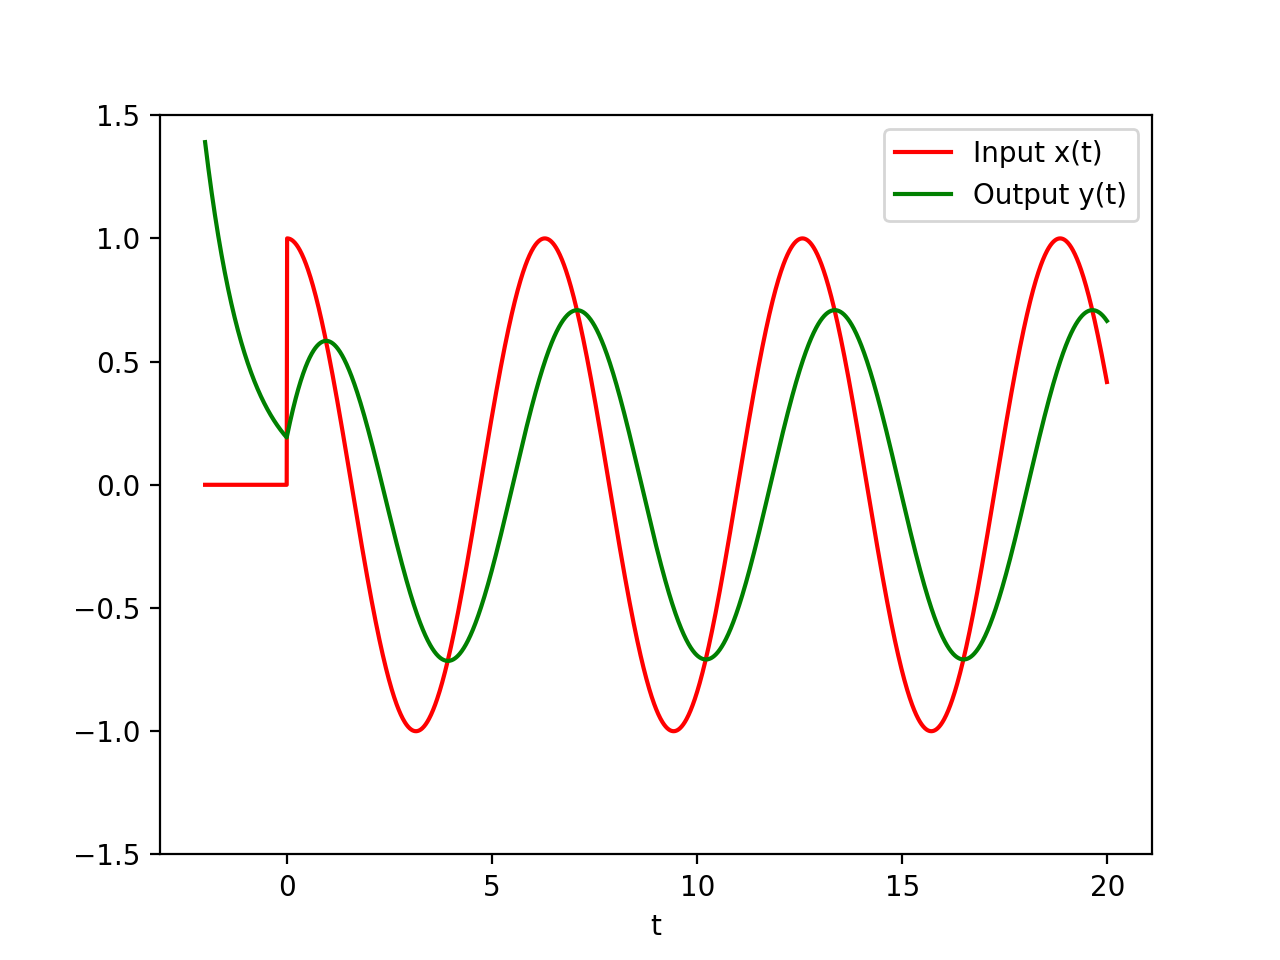

In [22]:
# Response for given initial condition
RC = 1;  TdRC = T/RC;
n0 = np.where(nv==0)[0][0];  # find location in nv with zero value
y0 = 0.2;
yv = rclowpass_resp(xv,n0,y0,TdRC,0);
fig = plt.figure();  ph = plt.plot(tv,xv,'r-',tv,yv,'g-');
plt.xlabel('t');  plt.legend(['Input x(t)','Output y(t)']);  plt.ylim((-1.5,1.5));

Some interesting observations can be made:

* Prior to time $t=0$ we see the output approaching the value $0.2$ from above.  We can understand this in terms of the original circuit.  Remember that for negative values of time the input voltage $x(t)$ is zero, so the voltage source on the left is a short circuit.  The capacitor is therefore simply discharging through the resistor.  Since the auxiliary condition says that at time $t=0$ the capacitor voltage must be $0.2$ volts, for negative time this voltage must have been positive and much bigger.<br><br>

* The initial onset of the signal occurs at $t=0$.  After some time has passed we see a simple relationship between the output and the input:  both are sinusoids at the same frequency, but the output is delayed relative to the input and its amplitude has been reduced.  We call this the steady-state response.  Essentially, for large $t$ the input is $x(t) = \cos(\omega_0 t)$ and the output can be written as $y(t) = A \cos(\omega_0 t + \theta)$ for some $A$ and $\theta$.<br><br>

* Just after $t=0$, but before the system has reached steady state, the output has a period of disturbance.  This transient depends on the initial conditions, but (since the system is stable) will die down after enough time has passed.  The steady-state response is independent of the initial conditions.

For the case shown above we can characterise the steady-steady state response for the driving frequency $\omega_0$ by estimating $A$ and $\theta$ for large $t$.  The following block of code calculates these estimates by finding the difference in position between the last positive peak in the output signal and the most recent earlier peak in the input, and expressing this as a phase.  Multiples of $2\pi$ are then added or subtracted until this phase is in the normal range $-\pi$ to $\pi$.

In [5]:
# Use local maxima for input and output signals to estimate gain and phase
from scipy.signal import argrelmax

xvlmi = argrelmax(xv)[0];  # locations of local maxima
yvlmi = argrelmax(yv)[0];
if len(xvlmi)<2 or len(yvlmi)<2:  raise RuntimeError  # not enough peaks found
xlmi = xvlmi[-1];  ylmi = yvlmi[-1];  # locations of last maximum

# Required quantities
gain = yv[ylmi]/xv[xlmi];  # ratio of peak amplitudes
tdelay = tv[xlmi] - tv[ylmi];  # time delay (seconds) output peak relative to input
theta = 2*np.pi*tdelay/T0;  # delay in units of radians
while theta<=np.pi:  theta = theta + 2*np.pi;  # add or subtract multiples of 2*pi until in (-pi.pi]
while theta>np.pi:  theta = theta - 2*np.pi;

print('Last output peak:  y(', tv[ylmi], ') =', yv[ylmi]);
print('Preceeding input peak:  x(', tv[xlmi], ') =', xv[xlmi]);
print('Gain:  A =', gain);
print('Phase lag:  theta =', theta, 'radians');

Last output peak:  y( 19.64 ) = 0.708880372464
Preceeding input peak:  x( 18.85 ) = 0.999999901397
Gain:  A = 0.708880442362
Phase lag:  theta = -0.79 radians


Some discussion of how the phase is represented is useful.  Shifting a signal by a phase of $2 \pi$ radians corresponds to a time shift of one cycle or one wavelength $T_0$, where $T_0 = 2 \pi/\omega_0$.  Thus, for example, a phase shift of $\pi$ corresponds to a time shift of half a wavelength, and $\pi/2$ to a shift of a quarter wavelength.  The actual length of this shift therefore depends on the particular frequency we're considering.

## Investigation

The code in the previous section is combined into a single script below.

In [7]:
%run src/labX_preamble.py  # For internal notebook functions

<IPython.core.display.Javascript object>


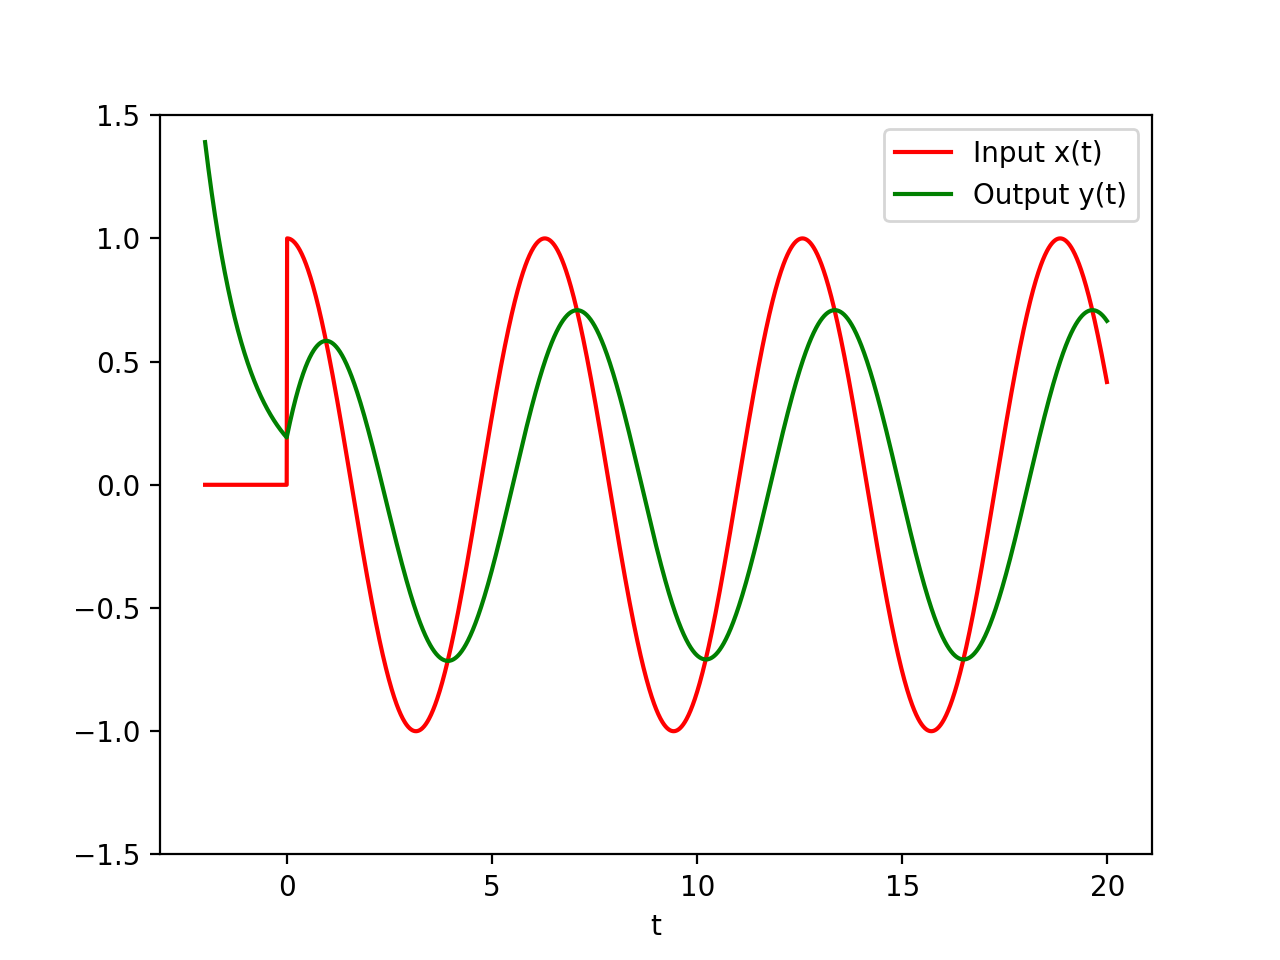

Last output peak:  y( 19.64 ) = 0.708880372464
Preceeding input peak:  x( 18.85 ) = 0.999999901397
Gain:  A = 0.708880442362
Phase lag:  theta = -0.79 radians


In [60]:
%%writefileexec src/lab_freqresprclp-1.py -s  # dump cell to file before execute

import numpy as np
from scipy.signal import argrelmax
import matplotlib.pyplot as plt
%matplotlib notebook

def rclowpass_resp(xv,n0,y0,TdRC,bflag=0):
    """RC lowpass output from given input using standard Euler 
    xv:  input signal (array)
    n0, y0:  auxiliary condition yv[n0] = y0
    TdRC:  value T/RC
    bflag:  method Euler forward (0) or backward (1)
    returns yv:  output signal (array)
    """
    
    yv = np.zeros(xv.shape);
    yv[n0] = y0;
    
    if bflag==0:
        # Forward Euler in each direction
        for n in range(n0,len(xv)-1):
            yv[n+1] = yv[n] + TdRC*(xv[n] - yv[n]);  # forward recursion
        for n in range(n0,0,-1):
            yv[n-1] = yv[n] - TdRC*(xv[n] - yv[n]);  # reverse recursion
    else:
        # Backward (implicit) Euler in each direction
        for n in range(n0,len(xv)-1):
            yv[n+1] = 1/(1+TdRC)*yv[n] + TdRC/(1+TdRC)*xv[n+1];  # forward recursion
        for n in range(n0,0,-1):
            yv[n-1] = 1/(1-TdRC)*yv[n] - TdRC/(1-TdRC)*xv[n-1];  # reverse recursion

    return yv;

# Input signal and discretisation
omega0 = 1;  # current frequency
T = 0.01;  # small number
if omega0==0:  T0 = np.inf;
else:  T0 = 2*np.pi/omega0;  # waveform period (seconds) for current omega0  
nv = np.arange(-200,2000);  # discrete signal indices n
tv = nv*T;  # time values corresponding to indices t=nT
xv = np.zeros(tv.shape);
for i in range(0,len(xv)):  xv[i] = np.cos(omega0*tv[i])*(tv[i]>=0); 
    
# Response for given initial condition
RC = 1;  TdRC = T/RC;
n0 = np.where(nv==0)[0][0];  # find location in nv with zero value
y0 = 0.2;
yv = rclowpass_resp(xv,n0,y0,TdRC,0);
fig = plt.figure();  ph = plt.plot(tv,xv,'r-',tv,yv,'g-');
plt.xlabel('t');  plt.legend(['Input x(t)','Output y(t)']);  plt.ylim((-1.5,1.5));

# Use local maxima for input and output signals to estimate gain and phase
xvlmi = argrelmax(xv)[0];  # locations of local maxima
yvlmi = argrelmax(yv)[0];
if len(xvlmi)<2 or len(yvlmi)<2:  raise RuntimeError  # not enough peaks found
xlmi = xvlmi[-1];  ylmi = yvlmi[-1];  # locations of last maximum

# Required quantities
gain = yv[ylmi]/xv[xlmi];  # ratio of peak amplitudes
tdelay = tv[xlmi] - tv[ylmi];  # time delay (seconds) output peak relative to input
theta = 2*np.pi*tdelay/T0;  # delay in units of radians
while theta<=np.pi:  theta = theta + 2*np.pi;  # add or subtract multiples of 2*pi until in (-pi.pi]
while theta>np.pi:  theta = theta - 2*np.pi;

print('Last output peak:  y(', tv[ylmi], ') =', yv[ylmi]);
print('Preceeding input peak:  x(', tv[xlmi], ') =', xv[xlmi]);
print('Gain:  A =', gain);
print('Phase lag:  theta =', theta, 'radians');

The following items involve investigations that you should perform to investigate the nature of the problem being addressed:

* Run the code above for the case of $\omega = 0$, where the input simply becomes the step function at the origin.  The method used for phase estimation will fail because there are no peaks, but the input-output plot is still correct.  By changing the value of $RC$ confirm that after about $5 RC$ seconds have passed the transient has decayed almost entirely away, and the system reaches its steady state (in this case DC) response.  Convince yourself that this is true regardless of the initial value $y_0$.  The quantity $\tau = RC$ is called the *time constant* of the circuit, and it determines the time duration of transients in the system.  Specifically, after one time constant the transient response will have decayed to $e^{-1} = 0.368 \approx 37\%$ of its initial value and after $k$ time constants the it will have decayed to $e^{-k}$ times its initial value.<br><br>

* Consider changing the frequency $\omega_0$ of the input.  Try for example $\omega_0 = 1, 2, 5, 10$ radians per second.  Make a note of the gain $A$ and phase lag $\theta$ for each case.  You should observe that the gain *decreases* as $\omega_0$ increases.  In other words the circuit attenuates high frequencies more than low frequencies, and is hence a lowpass filter.  Confirm that the steady-state gain and phase lags are independent of the initial conditions.<br><br>

* The method of using locations of peaks in input and output signals to determine the phase response requires $T$ to be sufficiently small for it to be reliable.  If we want an estimate accurate to one part in $60$, for example, then we need more than $60$ samples over a wavelength $T_0$, or $T<\frac{1}{60} T_0$.  With $\omega_0 = 2\pi/T_0$ and the value $T=0.01$ this provides a usable limit of $\omega_0 \leq 10$.<br><br>

* Observe that the code as written doesn't work for $\omega_0 = 0.1$, because the interval over which we've calculated signal values is too short for the peak search method to work.  Modify `nv` to calculate the signal over a longer time period using say `nv = np.arange(-2000,20000)`:  the method then works for $\omega_0 = 0.1$ but now fails for $\omega = 0.005$.  It also requires more computation.<br><br>

## Frequency representation and Bode plot

In this course we will see (or might already have seen) that the RC circuit has a transfer function
$$H(\omega) = \frac{1/RC}{1/RC + j \omega}.$$
This system has a real impulse response so $H(-\omega) = H^\ast(\omega)$.  The exact analytical form for the steady-state response to the input signal $x(t) = \cos(\omega t)$ is quite easily shown to be
$$y(t) = |H(\omega)| \cos(\omega t + \angle H(\omega)).$$
A plot of this magnitude and phase response calculated over a range of frequencies follows.  Also shown on the plot is a single point showing the gain and phase obtained from the time-domain response for the last calculated frequency.

<IPython.core.display.Javascript object>


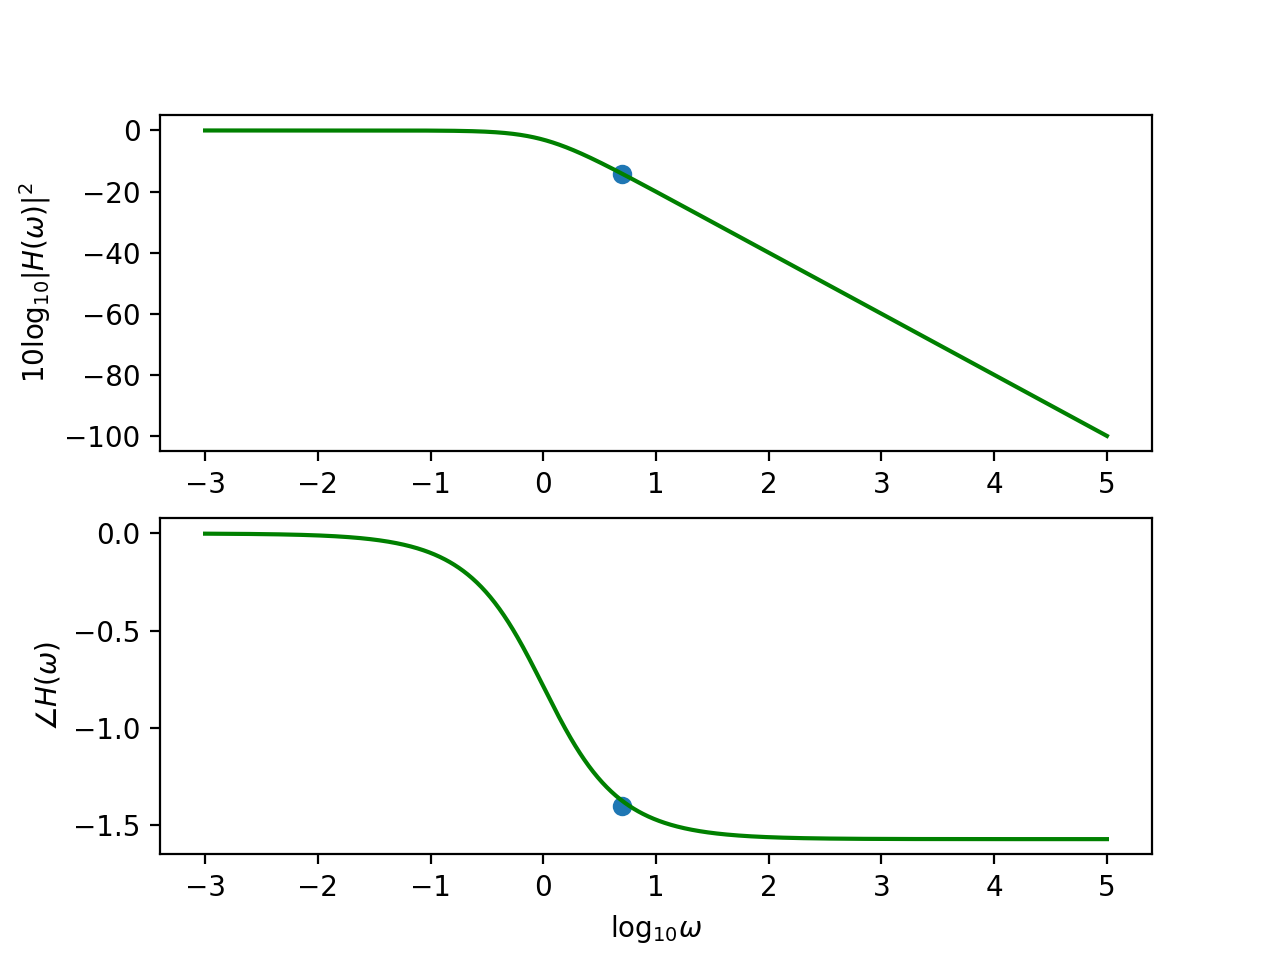

In [59]:
# One-sided Bode plot values log-log
lwv = np.linspace(-3, 5, 1000);  # linear points in log space
wv = 10**lwv;  # actual frequencies
Hv = (1/RC)/((1/RC)+1j*wv);  # frequency response
dbHv = 10*np.log10(np.abs(Hv)**2);  # magnitude response in dB

# Current point
lw0 = np.log10(omega0);
dbHvw0 = 10*np.log10(np.abs(gain)**2);

# Plot
fh, ax = plt.subplots(2);
ax[0].plot(lwv, dbHv, c='g');  ax[0].set_ylabel('$10 \log_{10} |H(\omega)|^2$');
ax[0].scatter(lw0, dbHvw0);
ax[1].plot(lwv, np.angle(Hv), c='g');  ax[1].set_ylabel(r'$\angle H(\omega)$');
ax[1].scatter(lw0, theta);
plt.xlabel('$\log_{10} \omega$');

# Tasks

These tasks involve writing code, or modifying existing code, to meet the objectives described.

1.  On a single set of axes make a plot of the step response $g(t)$ of an RC lowpass filter for the three cases $RC=1$, $RC=2$, and $RC=3$.  The domain of the plot should be from $t=-2$ to $t=15$.  Assume an initial rest condition $g(-2) = 0$.<br><br>

2.  Use the `rclowpass_resp` function definition and the subsequent snippets of code to "experimentally" calculate and plot the frequency response magnitude and phase of the RC circuit differential equation for the set of frequencies evenly-spaced in log-space $\log_{10} \omega = -1, -0.8, -0.6, \ldots, 1$.  Use $RC=1$.  Also include the theoretical reponse curves in your plot.<br><br>

3.  [DOES THIS WORK WITH THE SCOPES IN THE LAB?  CHANGE TO RC=0.01?]. Repeat the previous task, but using actual measurements obtained from an electrical circuit.  Build an RC circuit with $RC=1$ in the lab, and connect the input to a sinusoidal signal generator and the output to an oscilliscope.  Set the input to each of the frequencies specified above, and record the ratio of the output amplitude to the input amplitude (the gain).  Also measure the lag in seconds of the output relative to the input, convert it to an angle using the known frequency, and record it (the phase).  Plot these points on a graph along with the theoretical Bode plot for the system.